In [1]:
# Import ML libs
import math
import numpy as np
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array

# Import Keras libs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Import required libraries for visualization and printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import utility for time manupulation
import datetime
import time

#Import other libs
import os
from pathlib import Path

# Import libs for stock market datasets
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# Max allowed time delta
ALLOWED_DELTA = datetime.timedelta(days=7) 
model = None
predictions = None

def get_date():
    """ Return date in yyyy-mm-dd format """
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d")

def save_data(df,fileName):
    """ Saves data to csv file, file name is Ticker symbol """
    df.to_csv("data\\" + fileName)
    
def load_data(fileName):
    """ Load data from csv file, file name is Ticker symbol """
    return pd.read_csv("data\\" + fileName,infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
    
def data_exists(fileName):
    """ Check if file exists in data"""
    my_file = Path("data\\" + fileName )
    res = my_file.is_file()
    return res
    
def get_data(symbol, start_date='2000-01-01'):
    """ Download and return stock data """
    download_data = True
    if data_exists(symbol):
        # file exists
        data = load_data(symbol)
        #if date is current do not download data
        c_date = data.iloc[-1,0]
        if pd.to_datetime(get_date()) - pd.to_datetime(c_date) < ALLOWED_DELTA:
            download_data = False
    if download_data :  
        try:
            yf.pdr_override()
            # download dataframe
            data = pdr.get_data_yahoo(symbol, start=start_date)
        except ValueError:
            pass
        if Path(symbol).is_file():
            os.remove(symbol)
        save_data(data,symbol)
    return load_data(symbol)


def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill',inplace=True)  
    df_data.fillna(method='bfill',inplace=True)
    return df_data

def plot_val_data(df, val ,title="Plot Stock Feature",):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df[val].plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel(val)
    plt.show()
    
#split for train and test
def split_dataset (df, window = 7, train_percent = 0.7):
    number_of_rows = int(df.shape[0] / window) * window
    fd = df[-number_of_rows:]
    trfd_rows = int(int(fd.shape[0] * train_percent) / window) * window
    trfd = fd [:trfd_rows]
    tsfd_rows = int((df.shape[0] - trfd_rows) / window) * window
    tsfd = fd[-tsfd_rows:]
    trfd = array(split(trfd, len(trfd)/window))
    tsfd = array(split(tsfd, len(tsfd)/window))
    print(trfd.shape,tsfd.shape)
    return trfd,tsfd

# plot prediction vs actual
def plot_pred_v_test(predictions,test,show_last=100):
    test_base = test.reshape(-1,10)
    test_df = pd.DataFrame(test_base)
    predictions_r = predictions.reshape(-1,1)
    print(predictions_r.T[0,-7:])
    print(test_df.iloc[-7:,0].values)
    plt.plot(predictions_r.T[0,-100:],label="Predicted")
    plt.plot(test_df.iloc[-100:,0].values,label="Actual")  
    plt.title('Actual vs Predicted',fontsize=10)
    plt.xlabel('Last '+str(show_last)+' Days',fontsize=10)
    plt.ylabel('Adj Close Price (USD)',fontsize=10)
    plt.legend()
    plt.show()


Using TensorFlow backend.


In [2]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	print('Evaluating Forecast...')
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	print('Summarising Scores...')
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	print('Processing data in Supervised...')
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	print('Build Model...')
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	print('Evaluating Model...')
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores , predictions


In [3]:
def run_LSTM(ticker,lookback=100,daysInFuture=7):
    # load the new file
    dataset = load_data(ticker+'_processed')
    # split into train and test
    train, test = split_dataset(dataset.values)

    # evaluate model and get scores
    n_input = lookback
    score, scores , predicted = evaluate_model(train, test, n_input)

    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = []
    for i in range(daysInFuture):
        days.append('day'+str(i))
    plt.plot(days, scores, marker='o', label='lstm')
    plt.show()
    return predicted,test
    

In [4]:
### Run Models for all tickers

(477, 7, 10) (205, 7, 10)
Evaluating Model...
Build Model...
Processing data in Supervised...
Epoch 1/50
3318/3318 [==============================] - 5s 2ms/step - loss: 403.8904
Epoch 2/50
3318/3318 [==============================] - 5s 1ms/step - loss: 18.9134
Epoch 3/50
3318/3318 [==============================] - 5s 1ms/step - loss: 17.2402
Epoch 4/50
3318/3318 [==============================] - 5s 1ms/step - loss: 16.3957
Epoch 5/50
3318/3318 [==============================] - 4s 1ms/step - loss: 15.2038
Epoch 6/50
3318/3318 [==============================] - 4s 1ms/step - loss: 13.5220
Epoch 7/50
3318/3318 [==============================] - 4s 1ms/step - loss: 12.4080: 0s - los
Epoch 8/50
3318/3318 [==============================] - 4s 1ms/step - loss: 12.7058
Epoch 9/50
3318/3318 [==============================] - 5s 1ms/step - loss: 14.3437
Epoch 10/50
3318/3318 [==============================] - 4s 1ms/step - loss: 12.2590
Epoch 11/50
3318/3318 [==============================]

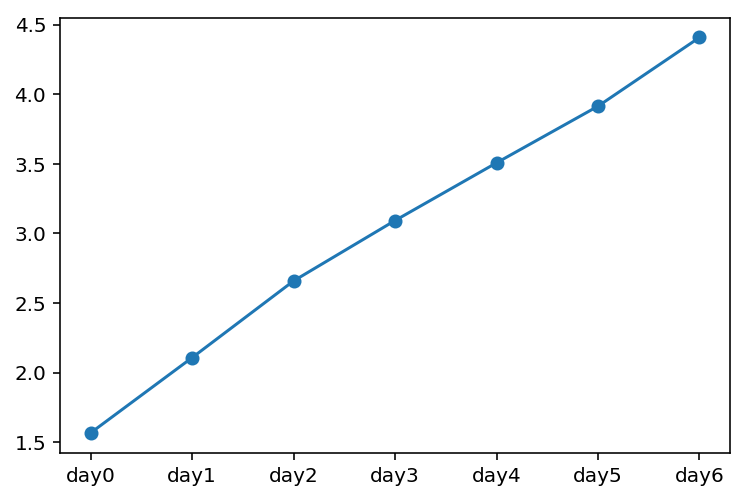

[115.10782 115.31509 115.2427  114.64319 115.95506 115.68619 114.8571 ]
[112.910004 117.32     118.150002 119.830002 120.690002 121.790001
 121.459999]


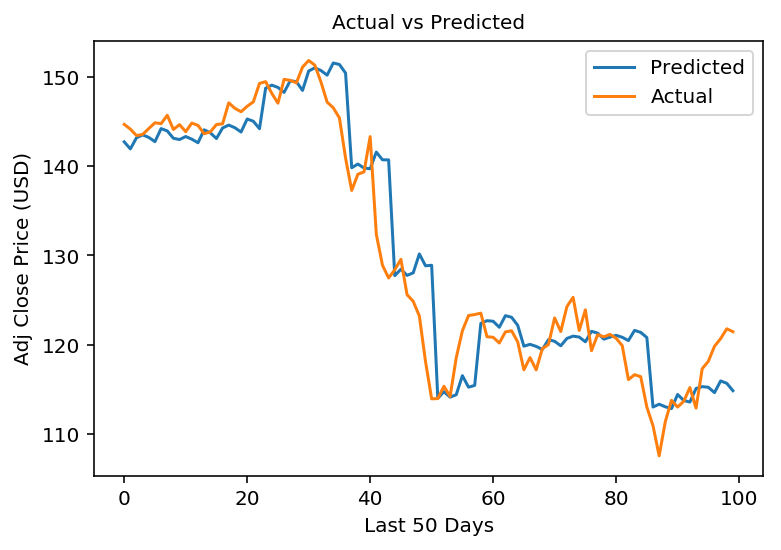

In [5]:
#for IBM
pred, tes = run_LSTM('IBM',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Evaluating Model...
Build Model...
Processing data in Supervised...
Epoch 1/50
3318/3318 [==============================] - 6s 2ms/step - loss: 18.5717
Epoch 2/50
3318/3318 [==============================] - 5s 2ms/step - loss: 2.1705
Epoch 3/50
3318/3318 [==============================] - 6s 2ms/step - loss: 2.1060
Epoch 4/50
3318/3318 [==============================] - 5s 1ms/step - loss: 2.3499
Epoch 5/50
3318/3318 [==============================] - 5s 1ms/step - loss: 2.5643
Epoch 6/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.6644
Epoch 7/50
3318/3318 [==============================] - 6s 2ms/step - loss: 1.9800
Epoch 8/50
3318/3318 [==============================] - 6s 2ms/step - loss: 1.6566
Epoch 9/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.9730
Epoch 10/50
3318/3318 [==============================] - 5s 1ms/step - loss: 1.3644
Epoch 11/50
3318/3318 [==============================] - 6s 2ms/step - los

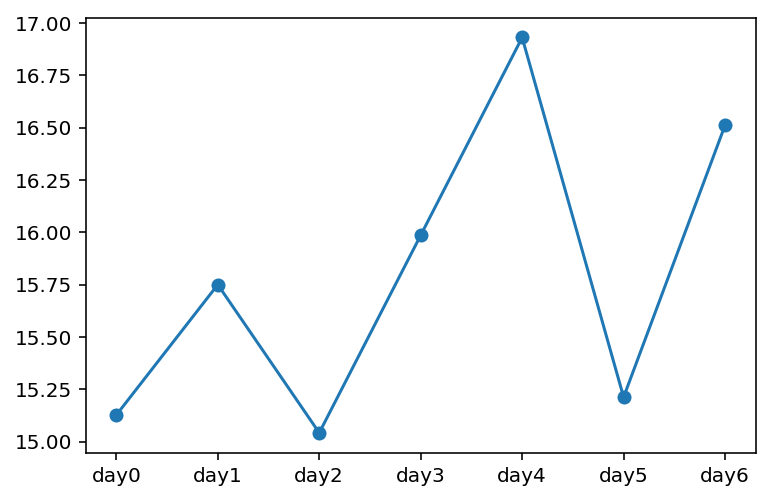

[156.72678 157.2654  156.23166 156.35246 155.09804 155.45741 156.11284]
[142.190002 148.259995 147.929993 150.75     153.309998 153.800003
 152.289993]


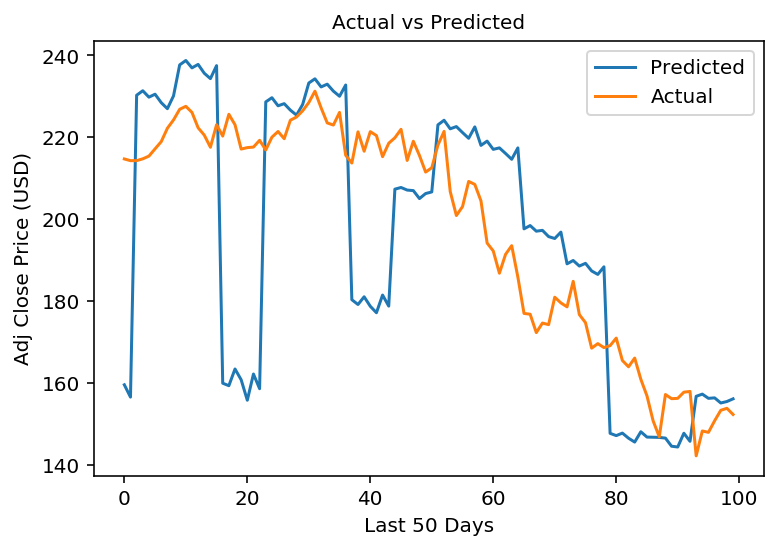

In [6]:
#for apple
pred, tes = run_LSTM('AAPL',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Evaluating Model...
Build Model...
Processing data in Supervised...
Epoch 1/50
3318/3318 [==============================] - 6s 2ms/step - loss: 10.4590
Epoch 2/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.5195
Epoch 3/50
3318/3318 [==============================] - 5s 1ms/step - loss: 1.4711
Epoch 4/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.1627
Epoch 5/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.0974
Epoch 6/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.1892
Epoch 7/50
3318/3318 [==============================] - 5s 2ms/step - loss: 1.0617
Epoch 8/50
3318/3318 [==============================] - 5s 1ms/step - loss: 0.9799
Epoch 9/50
3318/3318 [==============================] - 5s 1ms/step - loss: 0.9185
Epoch 10/50
3318/3318 [==============================] - 5s 2ms/step - loss: 0.8531
Epoch 11/50
3318/3318 [==============================] - 5s 2ms/step - los

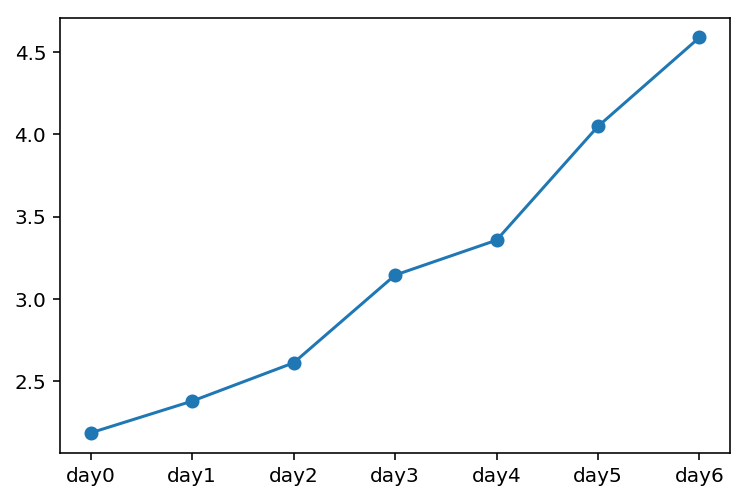

[104.6893   103.44413  102.56756  101.84689  101.72129  100.50744
  99.057175]
[ 97.400002 101.93     102.059998 102.800003 104.269997 103.599998
 102.800003]


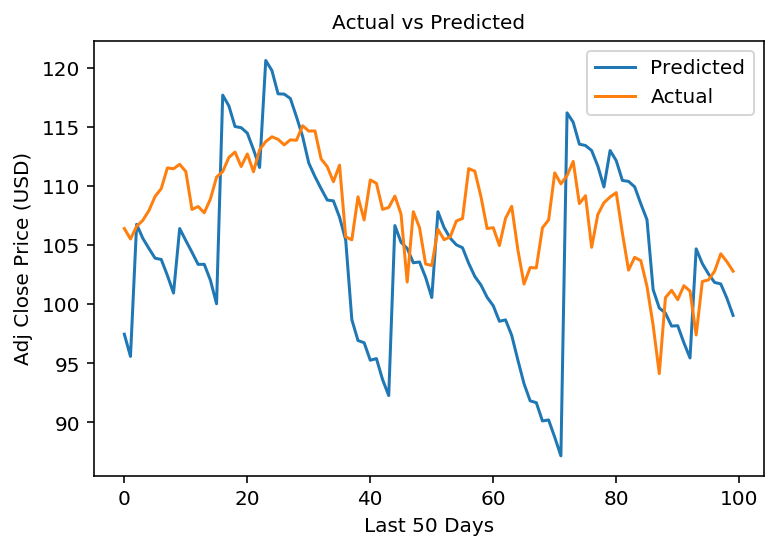

In [7]:
#for microsoft
pred, tes = run_LSTM('MSFT',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Evaluating Model...
Build Model...
Processing data in Supervised...
Epoch 1/50
3318/3318 [==============================] - 6s 2ms/step - loss: 404.3415
Epoch 2/50
3318/3318 [==============================] - 5s 1ms/step - loss: 56.6808
Epoch 3/50
3318/3318 [==============================] - 5s 1ms/step - loss: 54.7873
Epoch 4/50
3318/3318 [==============================] - 5s 1ms/step - loss: 56.1955
Epoch 5/50
3318/3318 [==============================] - 5s 1ms/step - loss: 51.9347
Epoch 6/50
3318/3318 [==============================] - 5s 2ms/step - loss: 51.2133
Epoch 7/50
3318/3318 [==============================] - 5s 1ms/step - loss: 45.3321
Epoch 8/50
3318/3318 [==============================] - 5s 1ms/step - loss: 44.4969
Epoch 9/50
3318/3318 [==============================] - 5s 1ms/step - loss: 45.9095
Epoch 10/50
3318/3318 [==============================] - 5s 1ms/step - loss: 44.3429
Epoch 11/50
3318/3318 [==============================] - 5s 1ms/

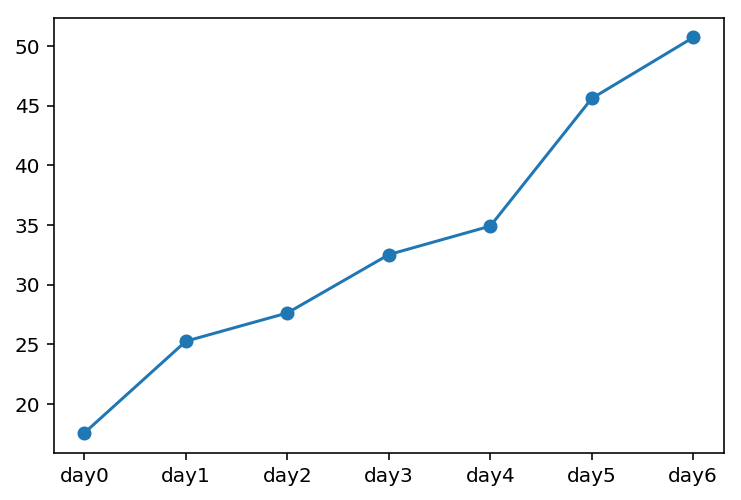

[1529.1124 1535.7913 1548.8339 1540.1244 1542.9523 1544.004  1538.0393]
[1500.280029 1575.390015 1629.51001  1656.579956 1659.420044 1656.219971
 1640.560059]


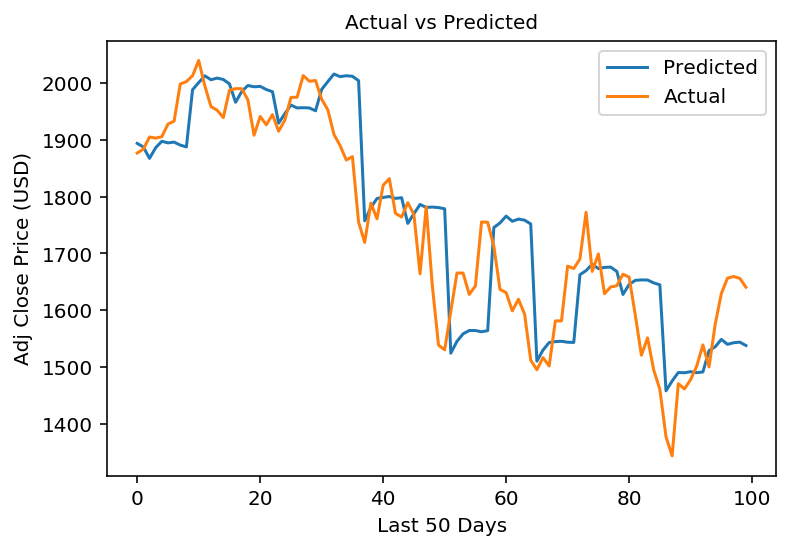

In [8]:
#for Amazon 
pred, tes = run_LSTM('AMZN',14)
plot_pred_v_test(pred, tes,50)

## Results 

In [ ]:
IBM      : lstm: [3.175] 1.6, 2.1, 2.7, 3.1, 3.5, 3.9, 4.4
Apple    : lstm: [15.809] 15.1, 15.8, 15.0, 16.0, 16.9, 15.2, 16.5
Amazon   : lstm: [35.133] 17.6, 25.3, 27.6, 32.5, 34.9, 45.6, 50.7
Microsoft: lstm: [3.292] 2.2, 2.4, 2.6, 3.1, 3.4, 4.0, 4.6